In [34]:
!python -m pip install --user -q -r ../requirements.txt

# Recurrent Neural Networks (RNNs)

Før Transformers kom på maskinlærings-banen, var det typisk RNNs man tok i bruk når man skulle modellere språk og tekst. En RNN jobber med sekvensiell data, som gjerne har uforutsigbar lengde. For å håndtere dette bruker man de samme parameterne på hvert element i sekvensen. RNNs har en form for hukommelse gjennom en _hidden state_, som propageres gjennom inference-prosessen. 

Det finnes flere varianter av RNNs, men den enkleste består av et lineært lag med en aktiveringsfunksjon i midten. Dette laget tar inn en sammenslått vektor bestående av den tidligere hidden state, samt en vektorrepresentasjon av det nåværende ordet i sekvensen. Figuren under illustrerer dette.

<img src="../res/vanilla-rnn.png" width="700px" height="auto" alt="SVG Image"/>


RNNs kan brukes til mye forskjellig, som sentiment-analyse, oversettelse mellom språk, og [navneenhetsgjenkjenning](https://en.wikipedia.org/wiki/Named-entity_recognition). I denne notebooken skal vi derimot trene en til å generere tekst. Vi skal rett og slett lage en forenklet mini-versjon av ChatGPT. Ytterligere krav til modellen blir da et ekstra lag som brukes på siste hidden state for å lage en sannsynlighetsfordeling over mulige ord. Arkitekturen ser da slik ut:



<img src="../res/vanilla-rnn-unrolled.svg" width="50%" height="auto" alt="SVG Image"/>

$h_0$ settes vanligvis til en vektor fylt med 0-ere.


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

RNNs er selvfølgelig tilgjengelig som en modul i Pytorch, gjennom [`torch.nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), men vi skal implementere denne selv for å bedre forstå hva som skjer 😄

In [45]:
# RNN model trained to predict the next word in a sentence
class VanillaRNN(nn.Module):
    def __init__(self, target_sentences, lr=0.001):
        super().__init__()

        # Preprocess the data
        self.target_sentences = [f"<START> {sentence.strip().lower()} <END>" for sentence in target_sentences] # Add start and end tokens to indicate the beginning and end of a sentence
        self.vocab = list(set(" ".join(self.target_sentences).split(" "))) # List of all unique words in the dataset
        self.vocab_size = len(self.vocab)

        self.hidden_size = 128 # Size of the hidden state that is passed between each word
        self.embedding_size = 64 # Size of the representation of each word


        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size) # Represent each word as a vector. This layer takes in a word index and outputs a vector of size embedding_size
        self.internal_layer = nn.Linear(self.embedding_size + self.hidden_size, self.hidden_size) # Combine embedding and previous hidden state to get new hidden state
        self.last_layer = nn.Linear(self.hidden_size, self.vocab_size) # Get logits for each word in the vocab

        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
    def tokenize(self, word):
        return torch.LongTensor([self.vocab.index(word)])

    def logits(self, sentence):
        # Initialize hidden state for sequence
        hidden = torch.zeros(1, self.hidden_size)

        # Process each token in the sequence
        split = sentence.split(" ")
        # Check if the word is in the vocab
        if not all([word in self.vocab for word in split]):
            raise ValueError("Word not in vocab")
        
        # Iterate through each word in the sequence
        for elem in split:
            token = self.tokenize(elem)
            embedding = self.embedding(token)
            input_data = torch.cat((embedding, hidden), dim=1)
            hidden = self.internal_layer(input_data)
            hidden = F.tanh(hidden)
            
        # The last hidden state should go through the last layer
        output = self.last_layer(hidden)

        return output
    
    def get_prob_dist_over_next_word(self, sentence: str):
        dist = self.forward(sentence)[0]
        return {self.vocab[i]: dist[i].item() for i in range(len(dist))}

    def forward(self, sentence):
        return F.softmax(self.logits(sentence), dim=1)
    
    def predict(self, sentence):
        result = self.vocab[torch.argmax(self.forward(sentence.strip()))]
        return result
    
    def complete_sentence(self, sentence, max_len=100):
        result = sentence.strip()
        new_token = ""
        while not new_token == "<END>":
            new_token = self.predict(result)
            if len(result.split(" ")) >= max_len:
                break
            result += " " + new_token
        return result

    def train(self, num_epochs=10):
        for epoch in tqdm(range(num_epochs), unit="epoch"):
            for sentence in self.target_sentences:
                split_sentence = sentence.split(" ")
                for i in range(len(split_sentence) - 1):
                    self.optimizer.zero_grad()
                    input_data = split_sentence[:i+1]
                    target = split_sentence[i+1]
                    output = self.forward(" ".join(input_data))
                    loss = self.loss_fn(output, self.tokenize(target))
                    loss.backward()
                    self.optimizer.step()
        
                        

Før vi trener modellen sjekker vi at den **ikke** klarer å skrive setninger som gir mening

In [46]:
target_sentences = ["dette er et kodekurs i maskinlæring", "kodekurset er gøy fordi man lærer mye"]
rnn = VanillaRNN(target_sentences)
rnn.complete_sentence("<START>")

'<START> kodekurs i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et <START> i et'

In [47]:
rnn.train(num_epochs=10)

100%|██████████| 10/10 [00:00<00:00, 33.28epoch/s]


In [40]:
rnn.complete_sentence("<START>")

'<START> dette er et kodekurs i maskinlæring <END>'

In [53]:
dist = rnn.get_prob_dist_over_next_word("<START> dette er et")
dist

{'<END>': 0.0013180046807974577,
 'maskinlæring': 0.0006277895881794393,
 'lærer': 0.002399436431005597,
 '<START>': 0.001338583999313414,
 'kodekurs': 0.9777529239654541,
 'et': 0.000896880985237658,
 'kodekurset': 0.002346424385905266,
 'i': 0.002105637453496456,
 'gøy': 0.0008360495558008552,
 'fordi': 0.006460241042077541,
 'man': 0.0005075365188531578,
 'mye': 0.0013211853802204132,
 'er': 0.0005924598663114011,
 'dette': 0.001496857963502407}

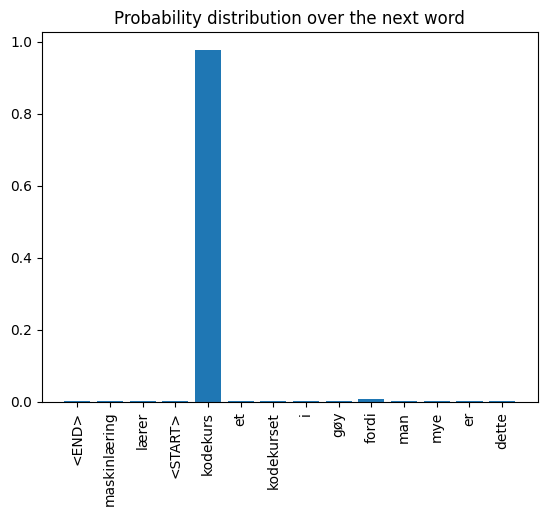

In [52]:
import matplotlib.pyplot as plt
plt.bar(dist.keys(), dist.values())
plt.xticks(rotation=90)
plt.title("Probability distribution over the next word")
plt.show()